## SPARC-4 mini-pipeline tools
# Science image reduction

This notebook shows an example for reducing a series of scientific images using the SPARC4 pipeline.

* Eder Martioli, LNA 10 Jun 2023

In [1]:
import os,sys
path_parent = os.path.dirname(os.getcwd())
# path_parent = "/Volumes/Samsung_T5/sparc4-pipeline/"
sys.path.append(path_parent) 
import sparc4_pipeline_lib as s4pipelib

## User inputs

In [2]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "all"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 3  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# uncomment below to set maximum number of files for stacking
p['NFILES_FOR_STACK'] = 16

## Define input calibrations
Here is where one should define the following calibrations:
* Master bias
* Master flat
* A file containing the reference WCS for an astrometric solution

In [3]:
# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)

# set reference image for astrometry
p["ASTROM_REF_IMG"] = p["ASTROM_REF_IMGS"][CHANNEL-1]

# Start reduction here

## 1. Reduce scientific exposures in `PHOTOMETRY` mode

There is already a stack image : /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_CR1_stack.fits


2023-06-12 18:00:46,158 astropop - INFO - reading file 0 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004298_cr1.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; retu

Running loop 0 of 1 -> images in loop: 0 to 5 ... 


2023-06-12 18:00:46,205 astropop - INFO - reading file 4 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004302_cr1.fits  [file_collection]


OBJECT files: 5
Creating output list of processed science frames ... 
1 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004298_cr1_proc.fits
2 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004299_cr1_proc.fits
3 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004300_cr1_proc.fits
4 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004301_cr1_proc.fits
5 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004302_cr1_proc.fits


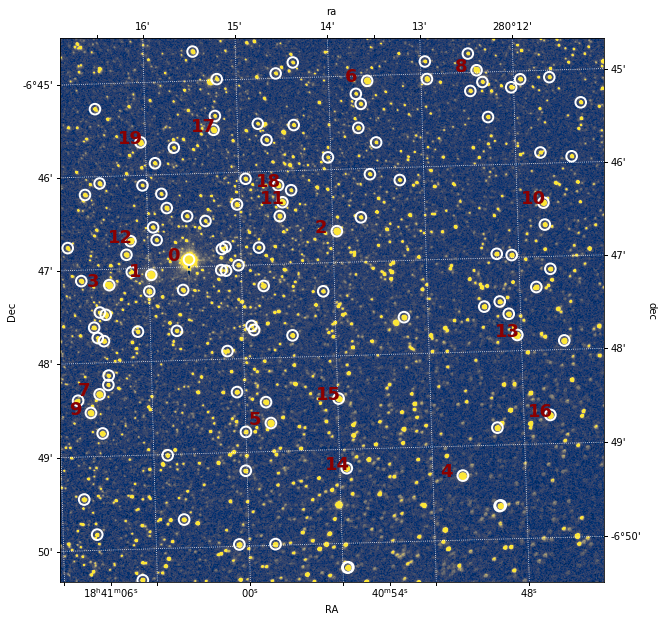

In [4]:
# loop over all objects observed in photometric mode
for obj in p['objsInPhot'][CHANNEL-1] :
    # reduce only a selected object or all objects 
    if obj == OBJECTID or OBJECTID == 'all':    
        # set suffix for stack product
        stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))

        # get full list of science objects in the current channel
        sci_list = p['objsInPhotdata'][CHANNEL-1][obj]

        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=False,
                                                  verbose=True,
                                                  plot=True)

## 2. Reduce scientific exposures in `POLARIMETRY HALF-WAVE` mode

There is already a stack image : /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_HD111579_POL_L2_stack.fits


2023-06-12 18:00:54,107 astropop - INFO - reading file 0 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002576_hd111.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; r

Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002576_hd111_proc.fits
2 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002577_hd111_proc.fits
3 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002578_hd111_proc.fits
4 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002579_hd111_proc.fits
5 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002580_hd111_proc.fits
6 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002581_hd111_proc.fits
7 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/m

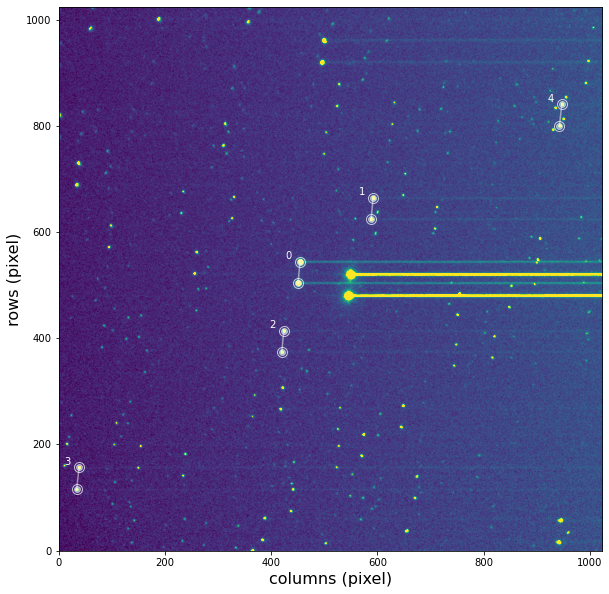

In [5]:
for obj in p['objsInPolarl2'][CHANNEL-1] :
    if obj == OBJECTID or OBJECTID == 'all':
        # set suffix for stack product        
        stack_suffix = "{}_s4c{}_{}_POL_L2".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))
        
        # get full list of science objects in the current channel
        sci_list = p['objsInPolarL2data'][CHANNEL-1][obj]
        
        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=True,
                                                  verbose=True,
                                                  plot=True)

## 3. Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE` mode

There is already a stack image : /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_HD111579_POL_L4_stack.fits


2023-06-12 18:00:59,266 astropop - INFO - reading file 0 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002592_hd1l4.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; r

Running loop 0 of 1 -> images in loop: 0 to 16 ... 


2023-06-12 18:00:59,354 astropop - INFO - reading file 6 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002598_hd1l4.fits  [file_collection]
2023-06-12 18:00:59,362 astropop - INFO - reading file 7 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002599_hd1l4.fits  [file_collection]
2023-06-12 18:00:59,369 astropop - INFO - reading file 8 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002600_hd1l4.fits  [file_collection]
2023-06-12 18:00:59,377 astropop - INFO - reading file 9 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002601_hd1l4.fits  [file_collection]
2023-06-12 18:00:59,384 astropop - INFO - reading file 10 from 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002602_hd1l4.fits  [file_collection]
2023-06-12 18:00:59,391 astropop - INFO - reading file 11 from 16: /Volumes/Samsung_T5/Data/SPARC4/minid

OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002592_hd1l4_proc.fits
2 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002593_hd1l4_proc.fits
3 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002594_hd1l4_proc.fits
4 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002595_hd1l4_proc.fits
5 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002596_hd1l4_proc.fits
6 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002597_hd1l4_proc.fits
7 of 16 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_

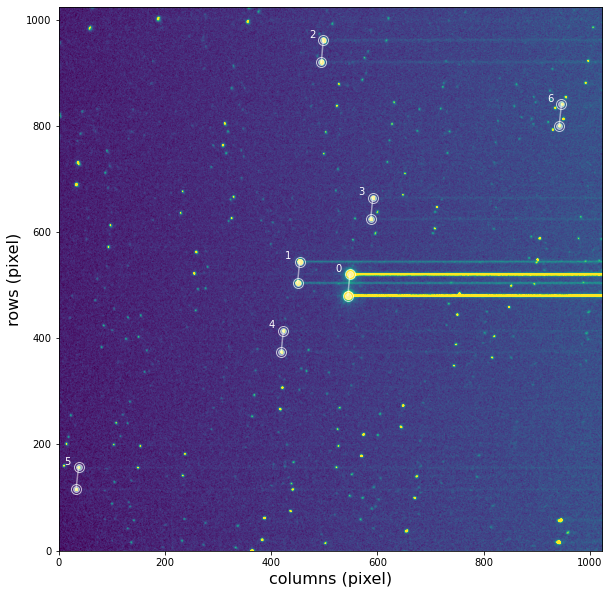

In [6]:
for obj in p['objsInPolarl4'][CHANNEL-1] :
    if obj == OBJECTID or OBJECTID == 'all':  
        # set suffix for stack product                
        stack_suffix = "{}_s4c{}_{}_POL_L4".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))

        # get full list of science objects in the current channel
        sci_list = p['objsInPolarL4data'][CHANNEL-1][obj]        
        
        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=True,
                                                  verbose=True,
                                                  plot=True)